## Producing book recommendations 

To ground my learning in a practical problem, I'll be using the [Goodbooks-10k dataset](http://fastml.com/goodbooks-10k-a-new-dataset-for-book-recommendations/) 

[Goodbooks](https://www.goodbooks.io/)  is an online book recommendation service that pairs readers with their next favourite read. The dataset contains information on 10,000 books from the service’s catalogue, along with ~80,000 reviews generated by site visitors. I’ll use this rich information to try our best to recommend what good books you (or your friends/family) should read next.


### Dataset overview: Brief EDA

I'll be making use of two main files derived from the dataset$^*$;
 
 - **Books_with_tags.csv**: I created this file for the convenience of this train. It contains book_id, title, author, date, etc. data from the original `books.csv` file, along with user tags merged from the `book_tags.csv` and `tags.csv` files. 
 
 
 - **Book_ratings.csv**: This is a subset of the `ratings.csv` file, with a field for the book titles added for convenience. This file contains the important mapping between users and item ratings.
 
The full dataset can be found [here](https://github.com/zygmuntz/goodbooks-10k).

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import heapq
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import scipy as sp

In [13]:
# Load the datasets
books_df = pd.read_csv('books.csv')
book_tags_df = pd.read_csv('book_tags.csv')
tags_df = pd.read_csv('tags.csv')
ratings_df = pd.read_csv('ratings.csv')

In [14]:
# Display column names for debugging
print("Books DataFrame columns:", books_df.columns)
print("Book Tags DataFrame columns:", book_tags_df.columns)
print("Tags DataFrame columns:", tags_df.columns)

Books DataFrame columns: Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url'],
      dtype='object')
Book Tags DataFrame columns: Index(['goodreads_book_id', 'tag_id', 'count'], dtype='object')
Tags DataFrame columns: Index(['tag_id', 'tag_name'], dtype='object')


In [20]:
# Merge book_tags with tags to get tag names
book_tags_merged = pd.merge(book_tags_df, tags_df, left_on='tag_id', right_on='tag_id')

# Aggregate tags for each book
book_tags_aggregated = book_tags_merged.groupby('goodreads_book_id')['tag_name'].apply(list).reset_index()

# Display the first few rows for debugging
print("Aggregated Book Tags DataFrame:", book_tags_aggregated.head())

# Merge with books data
books_with_tags_df = pd.merge(books_df, book_tags_aggregated, left_on='book_id', right_on='goodreads_book_id', how='left')

# Check for the existence of 'goodreads_book_id' before dropping
if 'goodreads_book_id' in books_with_tags_df.columns:
    books_with_tags_df.drop(columns=['goodreads_book_id'], inplace=True)

# Merge ratings with books to get book titles
book_ratings_df = pd.merge(ratings_df, books_df[['book_id', 'title']], on='book_id', how='left')

Aggregated Book Tags DataFrame:    goodreads_book_id                                           tag_name
0                  1  [to-read, fantasy, favorites, currently-readin...
1                  2  [to-read, fantasy, favorites, currently-readin...
2                  3  [to-read, fantasy, favorites, currently-readin...
3                  5  [to-read, fantasy, favorites, currently-readin...
4                  6  [to-read, fantasy, young-adult, fiction, harry...


In [16]:
# Save the dataframes to CSV
books_with_tags_df.to_csv('Books_with_tags.csv', index=False)
print("Books_with_tags.csv created successfully!")

book_ratings_df.to_csv('Book_ratings.csv', index=False)
print("Book_ratings.csv created successfully!")

Books_with_tags.csv created successfully!
Book_ratings.csv created successfully!


In [10]:
books = pd.read_csv('Books_with_tags.csv')
books.head(3)

,book_id,goodreads_book_id_x,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,goodreads_book_id_y,tag_name
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,1.0,"['to-read', 'fantasy', 'favorites', 'currently..."
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,2.0,"['to-read', 'fantasy', 'favorites', 'currently..."
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,3.0,"['to-read', 'fantasy', 'favorites', 'currently..."


In [11]:
print (f'Number of books in dataset: {books.shape[0]}')

Number of books in dataset: 10000


In [2]:
book_ratings = pd.read_csv('Book_ratings.csv')
book_ratings.head(3)

,user_id,book_id,rating,title
0,1,258,5,The Shadow of the Wind (The Cemetery of Forgot...
1,2,4081,4,I am Charlotte Simmons
2,2,260,5,How to Win Friends and Influence People


In [35]:
print (f'Number of ratings in dataset: {book_ratings.shape[0]}')

Number of ratings in dataset: 5976479


Let's look at the distribution of the ratings given by users. Here, we see that readers generally are on the kinder end of the rating spectrum, with a far higher proportion of positive reviews (> 3) being given over negative ones (< 3):

Average rating in dataset: 3.9198655261735214


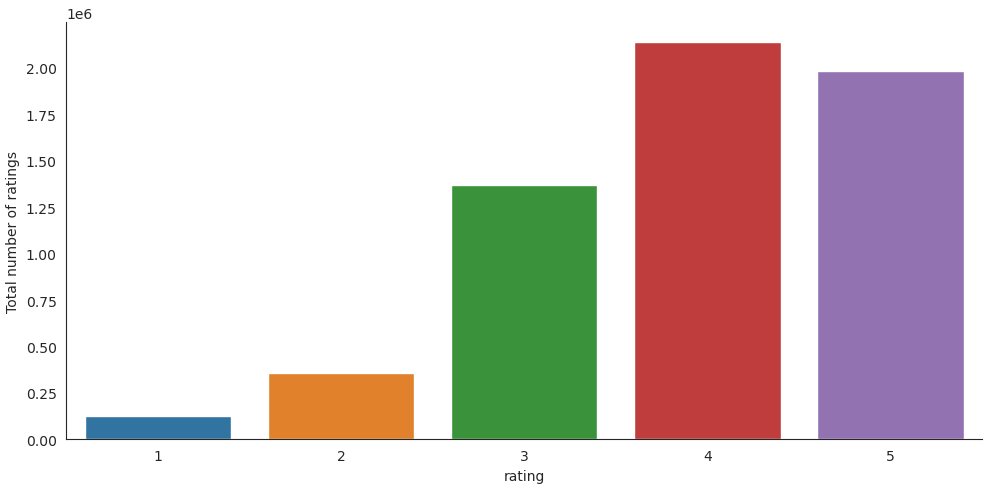

In [38]:
with sns.axes_style('white'):
    g = sns.catplot(data=book_ratings, x="rating", y=None, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")
print (f'Average rating in dataset: {np.mean(book_ratings["rating"])}')

That's enough spelunking through our data. Let’s go ahead and make a recommendation system.

The first step is generating recommendations using content-based filtering.

## Content-based filtering 

### How it works 

<br></br>

<div align="center" style="width: 800px; font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Content_filtering.jpg"
     alt="Content-based Filtering"
     style="float: center; padding-bottom=0.5em"
     width=800px/>
A depiction of the decision process used to recommend items within content-based filtering algorithms.  
</div>

In Content-based filtering, we seek to make recommendations based on **how similar an item's properties or features are to those of other items.**

Let's use the image above to help us see how this works. Ebrahem is an avid reader who has just finished the novel "The Golden Compass". Besides the written contents inside this book (item), it has certain attributes or properties which further describe it - such as the author ("Philip Pullman"), genre ("fantasy"), or target audience ("young adult"). These properties are not unique to this novel, as other books also have authors, genres, target audiences, etc. As such, we can compare the properties of different books with the assumption that books which have properties in common (such as author or genre) are similar to one another. We can further **assume that individuals like similar items**. For our example, this means that Ebrahem, if using content-based filtering to recommend him next book, would have a book such as "Harry Potter and the Philosopher's Stone" suggested to him over Anne Frank's "The Diary of a Young Girl", as the former novel is far more 'similar' to The Golden Compass.     

So let's see how we would implement a system like this in real life.

### Implementation 

Let's implement a straightforward content filtering-based recommendation algorithm.

To begin, we need to gather the various properties of our items so that we can convert them into meaningful features. Following along from our example above, we're going to use the `tag_name` field for each book as a representation of properties such as genre, time-period, and target audience. We're also going to consider the `authors` field, as individuals often enjoy reading novels written by the same author. 

We start off by creating a new column in our `books` dataframe called `auth_tags`, which contains the above-motivated contents for each item. We additionally create two pandas series objects to help us translate between book titles and indexes of our dataframe.  

In [40]:
books['auth_tags'] = (pd.Series(books[['authors', 'tag_name']]
                      .fillna('')
                      .values.tolist()).str.join(' '))

# Convenient indexes to map between book titles and indexes of 
# the books dataframe
titles = books['title']
indices = pd.Series(books.index, index=books['title'])

In [41]:
indices['Harry Potter and the Half-Blood Prince (Harry Potter, #6)']

26

In [43]:
books.iloc[26]

book_id                                                                     27
goodreads_book_id_x                                                          1
best_book_id                                                                 1
work_id                                                               41335427
books_count                                                                275
isbn                                                                 439785960
isbn13                                                         9780439785970.0
authors                                            J.K. Rowling, Mary GrandPré
original_publication_year                                               2005.0
original_title                          Harry Potter and the Half-Blood Prince
title                        Harry Potter and the Half-Blood Prince (Harry ...
language_code                                                              eng
average_rating                                      

We now need a mechanism to convert these textual features into a format that enables us to compute their relative similarities. This will allow us to translate our string-based collection of tags and authors into numerical vectors (see [here](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) for an overview of this process which is very similar to [count-based vectorization](https://youtu.be/W9VtEVBdgnQ)).

In [60]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2),
                     min_df=0.0, stop_words='english')

# Produce a feature matrix, where each row corresponds to a book,
# with TF-IDF features as columns 
tf_authTags_matrix = tf.fit_transform(books['auth_tags'])

We can now compute the similarity between each vector within our matrix. This is done by making use of the `cosine_similarity` function provided to us by `sklearn`.

In [61]:
cosine_sim_authTags = cosine_similarity(tf_authTags_matrix, 
                                        tf_authTags_matrix)
print (cosine_sim_authTags.shape)

(10000, 10000)


In [62]:
cosine_sim_authTags[:5]

array([[1.        , 0.74398183, 0.92355189, ..., 0.20924068, 0.        ,
        0.        ],
       [0.74398183, 1.        , 0.70984673, ..., 0.20028835, 0.        ,
        0.        ],
       [0.92355189, 0.70984673, 1.        , ..., 0.23585502, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.92578186, 0.71023653, 0.94735739, ..., 0.22650391, 0.        ,
        0.        ]])

The resulting structure is a $10000 \times 10000$ dense similarity matrix $S^I$, where the value of the entry in the $i^{th}$ row and $j^{th}$ column, $S^I_{i,j}$, corresponds to the similarity of books $i$ and $j$ within our dataset.

Using this notation, if $i$ and $j$ are the same number (i.e. all the diagonal entries in $S^I$), then the similarity value is equal to 1 (an item is completely similar to itself).  

#### Top-N recommendations

With our content similarity matrix computed, we're now ready to make some recommendations! Let's begin by generating a top-N list of books similar to the one which we prompt the system with.    

Following along from our earlier algorithmic explanation, we do this by: 

  1. Select an initial item (book) from which to generate recommendations. 
  2. Extract all the similarity values between the initial item and each other item in the similarity matrix.
  3. Sort the resulting values in descending order. 
  4. Select the top N similarity values and return the corresponding item details to the user. This is now our simple top-N list.  
  
We implement this algorithmic process in the function below:

In [63]:
def content_generate_top_N_recommendations(book_title, N=10):
    # Convert the string book title to a numeric index for our 
    # similarity matrix
    b_idx = indices[book_title]
    # Extract all similarity values computed with the reference book title
    sim_scores = list(enumerate(cosine_sim_authTags[b_idx]))
    # Sort the values, keeping a copy of the original index of each value
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Select the top-N values for recommendation
    sim_scores = sim_scores[1:N]
    # Collect indexes 
    book_indices = [i[0] for i in sim_scores]
    # Convert the indexes back into titles 
    return titles.iloc[book_indices]

With our function defined, let's test our simple content-based recommender on some sample book titles:

In [64]:
content_generate_top_N_recommendations("The Hobbit", N=10)

18      The Fellowship of the Ring (The Lord of the Ri...
154            The Two Towers (The Lord of the Rings, #2)
160     The Return of the King (The Lord of the Rings,...
188     The Lord of the Rings (The Lord of the Rings, ...
963     J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...
4975         Unfinished Tales of Númenor and Middle-Earth
2308                                The Children of Húrin
610              The Silmarillion (Middle-Earth Universe)
8271                   The Complete Guide to Middle-Earth
Name: title, dtype: object

In [65]:
content_generate_top_N_recommendations("Romeo and Juliet", N=10)

8599                                         Train Dreams
1822            A Bear Called Paddington (Paddington, #1)
5754                     Valiant (Modern Faerie Tales #2)
3109    Dragon Ball, Vol. 1: The Monkey King (Dragon B...
27                                      Lord of the Flies
6750    The Declaration of Independence and The Consti...
4920                       Magic Rises (Kate Daniels, #6)
6747                                 Uganda Be Kidding Me
9790                                       A Window Opens
Name: title, dtype: object

In [66]:
content_generate_top_N_recommendations("The Diary of a Young Girl", N=10)

8027             Anne Frank's Tales from the Secret Annex
2942                                    The Weird Sisters
1895                            Pollyanna (Pollyanna, #1)
1919                                       The Luminaries
2099                   Batman: The Dark Knight Returns #1
2503    Sin City, Vol. 1: The Hard Goodbye (Sin City, #1)
3941    Sin City, Vol. 2: A Dame to Kill For (Sin City...
3994    Sin City, Vol. 4: That Yellow Bastard (Sin Cit...
8213    Sin City, Vol. 3: The Big Fat Kill (Sin City, #3)
Name: title, dtype: object

Having seen the results of these top-N lists, a couple of observations can be made. 

- First, our recommendations seem to be strongly centred around the author of the reference book. For example,  other works by Tolkien and are highly recommended when using reference searches for "The Hobbit". This could be a natural result of the fact that an author's name is far less common in the dataset than other textual features such as genre. As such, books which share an author will be regarded as being far more similar.  


 - Second, in cases where the reference author has not written multiple book titles, such as Anne Frank (The Diary of a Young Girl), the recommendations produced are more varied and cover multiple titles in the same or similar genres. 

 
Based on these observations, we can ask if, in fact, the recommendations for "The Hobbit" are actually any good. After all, a reader who knows of Tolkien will often already know of other books these authors have written as well. This is where some of the subjective metrics (such as diversity), can be used to penalize these recommendations and help discover better ones.

#### Rating Prediction

In some cases, we may wish to calculate directly what rating a user _would_ give a book that they haven't read yet.

We can modify our content-based filtering algorithm to do this in the following manner: 

   1. Select a reference user from the database and a reference item (book) they have _not_ rated. 
   2. For the user, gather the similarity values between the reference item and each item the user _has_ rated. 
   3. Sort the gathered similarity values in descending order. 
   4. Select the $k$ highest similarity values, which are above a given threshold value, creating a collection $K$. 
   5. Compute a weighted average rating from these values, which is the sum of the similarity values of each item multiplied by its assigned user rating, divided by the sum of the similarity values. This can be expressed in the formula as:
   
   $$ \hat{R}_{ju} = \frac{\sum_{i \in K} s_{ij} \times r_{iu}}{\sum_{i \in K} s_{ij}}   $$
   
   where $\hat{R}_{ju}$ is the weighted average computed for the reference item $j$ and reference user $u$, $K$ is the collection of items, $s_{ij}$ is the similarity computed between items $i$ and $j$, and $r_{iu}$ is the known rating user $u$ has given item $i$.
   6. We return the weighted average $\hat{R}_{ju}$ as the prediction for our reference item.
   
   
We implement this algorithmic process in the function below:

In [72]:
def content_generate_rating_estimate(book_title, user, rating_data, k=20, threshold=0.0):
    # Convert the book title to a numeric index for our similarity matrix
    b_idx = indices[book_title]
    neighbors = [] # <-- Stores our collection of similarity values 
    
    # Gather the similarity ratings between each book the user has rated
    # and the reference book 
    for index, row in rating_data[rating_data['user_id']==user].iterrows():
        sim = cosine_sim_authTags[b_idx-1, indices[row['title']]-1]
        neighbors.append((sim, row['rating']))
    # Select the top-N values from our collection
    k_neighbors = heapq.nlargest(k, neighbors, key=lambda t: t[0])

    # Compute the weighted average using similarity scores and 
    # user item ratings. 
    simTotal, weightedSum = 0, 0
    for (simScore, rating) in k_neighbors:
        # Ensure that similarity ratings are above a given threshold
        if (simScore > threshold):
            simTotal += simScore
            weightedSum += simScore * rating
    try:
        predictedRating = weightedSum / simTotal
    except ZeroDivisionError:
        # Cold-start problem - No ratings given by user. 
        # We use the average rating for the reference item as a proxy in this case 
        predictedRating = np.mean(rating_data[rating_data['title']==book_title]['rating'])
    return predictedRating

With our algorithm defined, let's quickly test it out to see some results. 

To help us get a sense of the relevance and accuracy of these ratings, we select a lucky user (number 314) and consider their historical data: 

In [73]:
# Subset of ratings from user 314
book_ratings[book_ratings['user_id'] == 314][3:10]

,user_id,book_id,rating,title
145880,314,7293,4,The Last Don
146697,314,1457,3,Bridget Jones: The Edge of Reason (Bridget Jon...
146698,314,75,3,"Bridget Jones's Diary (Bridget Jones, #1)"
146700,314,236,3,Into Thin Air: A Personal Account of the Mount...
146701,314,4418,4,The Partly Cloudy Patriot
146707,314,2673,5,"Rainbow Six (Jack Ryan Universe, #10)"
146708,314,1817,3,"Sahara (Dirk Pitt, #11)"


We first generate some ratings for books which user 314 has already rated:

In [75]:
title = "The Last Don"
actual_rating = book_ratings[(book_ratings['user_id'] == 314) & (book_ratings['title'] == title)]['rating'].values[0]
pred_rating = content_generate_rating_estimate(book_title=title, user=314, rating_data=book_ratings)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

Title - The Last Don
---
Actual rating: 		 4
Predicted rating: 	 3.827669621165894


We repeat this process, but now for similar titles which have not been rated:  

In [76]:
title = "The Hobbit"
pred_rating = content_generate_rating_estimate(book_title=title, user=314, rating_data=book_ratings)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t ?")
print (f"Predicted rating: \t {pred_rating}")

Title - The Hobbit
---
Actual rating: 		 ?
Predicted rating: 	 3.8040890904472753


In [77]:
title = "Dune (Dune Chronicles #1)"
pred_rating = content_generate_rating_estimate(book_title=title, user=314, rating_data=book_ratings)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t ?")
print (f"Predicted rating: \t {pred_rating}")

Title - Dune (Dune Chronicles #1)
---
Actual rating: 		 ?
Predicted rating: 	 3.878583454129805


Based on the above results, our content-based ratings seem to be pretty good - being out by less than 1 rating point per known prediction! While we can't make the same judgement for the predicted ratings of the unseen books, they are close to known book ratings which are similar in nature, which is a promising sign.

## Collaborative-based Filtering 

### How it works

<br></br>

<div align="center" style="width: 700px; font-size: 80%; text-align: center; margin-left: 80px">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Utility_Matrix.jpg"
     alt="Collaborative-based Filtering - Utility Matrix"
     style="float: center; padding-bottom=0.5em"
     width=700px/>
Utility matrix used to assess the similarity between users who have rated items. 
</div>

In content-based filtering, we looked at the similarity between the properties or attributes of items. In collaborative-based filtering, **we measure the similarity between users to make recommendations**.

To see how this works, consider several individuals who are currently using our collaborative-based recommender system. Simon, Kwanda, Kieran and Joanne have all rated certain books that they've read, and we've been able to capture these results. Using this information, we can construct what is known as a **Utility Matrix**, which (as shown in the figure above) is a structure simply capturing our rating data in a formal way. In the utility matrix, each user is represented as a row$^*$, and the items (books) in our catalogue make up features for each user - whether they have rated a book or not, and what ratings they have given. We note here importantly that this matrix is inherently *sparse*, as there are far more items available in the catalogue than a user's supplied ratings.  

Using the structured information in the utility matrix, we can measure how similar users are to one another based on their rating characteristics. Using our example to help make this point, consider how Joanne and Simon could be considered to be similar as both have read the novels "Pride and Prejudice" and "The Diary of a Young Girl", and have given very similar ratings for both. On the other hand, even though Kwanda has also read and similarly rated "The Diary of a Young Girl", he would still be considered less similar to a user like Simon as they have fewer book reviews in common. 

Using this principle of user similarity, when we seek to make a recommendation for a user based on collaborative filtering, we usually seek to determine the *k-neighbors* who are most similar to the user. From these users, we then extract their highly-rated items and use these as a basis for recommendations. 

One powerful argument of why using user similarity is favourable, compared to that of item similarity, lies in recommendation variety. When looking at our content-based recommendations, we observed that the items suggested tended to be homogeneous; they were all by the same author or genre etc. But humans aren't homogeneous all the time - we like different things in different categories and at different times. As collaborative filtering considers similar individuals, it also considers similarities across categories, allowing recommendations to be more varied and natural.

A major downside to this approach, however, is described by what is known as the **'Cold-start problem'**. Consider, for example, user Kieran, who has just recently joined our recommender service. He has supplied only one rating; he seems to absolutely love "The Hunger Games". The problem is that no one else in our service has rated that book, and Kieran hasn't rated anything else as well. This means that we cannot get a similarity between Kieran and any other user - making our collaborative approach infeasible! While there are various ways of getting around this problem (we see a simple example in our implementation), the Cold-start problem is an ongoing challenge which continues to haunt recommender system researchers.

$^*$*Note that this isn't always the case, as it's perfectly acceptable for the utility matrix to have rows representing items and columns representing users. The important thing is that we are mapping ratings from users to items in one form or another.*  

### Dataset Overview

Once again, we will be using the **Book_rating.csv** dataset derived from the [Goodbooks-10k dataset](https://github.com/zygmuntz/goodbooks-10k)


In [78]:
book_ratings.head()

,user_id,book_id,rating,title
0,1,258,5,The Shadow of the Wind (The Cemetery of Forgot...
1,2,4081,4,I am Charlotte Simmons
2,2,260,5,How to Win Friends and Influence People
3,2,9296,5,The Drama of the Gifted Child: The Search for ...
4,2,2318,3,The Millionaire Next Door: The Surprising Secr...


In [79]:
print (f'Number of ratings in dataset: {book_ratings.shape[0]}')

Number of ratings in dataset: 5976479


## For memory consideration:
we will use the first 40000 of the data.

In [13]:
book_ratings_reduced = book_ratings.iloc[:40000, :]
book_ratings_reduced.head()

,user_id,book_id,rating,title,neat_title
0,1,258,5,The Shadow of the Wind (The Cemetery of Forgot...,The Shadow of the Wi
1,2,4081,4,I am Charlotte Simmons,I am Charlotte Simmo
2,2,260,5,How to Win Friends and Influence People,How to Win Friends a
3,2,9296,5,The Drama of the Gifted Child: The Search for ...,The Drama of the Gif
4,2,2318,3,The Millionaire Next Door: The Surprising Secr...,The Millionaire Next


### Implementation 

We now implement a simple collaborative filtering-based recommendation algorithm.

In a similar process to content filtering, where we first had to gather item features before we could compute their similarity, within collaborative filtering, we initially needed to gather all user ratings together by forming a utility matrix.

Using `pandas`, we can construct our utility matrix easily by using the `pivot_table` function:

This following cells might take some time to run.

In [14]:
util_matrix = book_ratings_reduced.pivot_table(index=['user_id'], 
                                       columns=['title'],
                                       values='rating') 
util_matrix.shape

(819, 4069)

We previously mentioned that the utility matrix is sparse, as it is unlikely that a user has read many of the books within the entire Goodbooks library. To illustrate this point, let's visualise a portion of the utility matrix: 

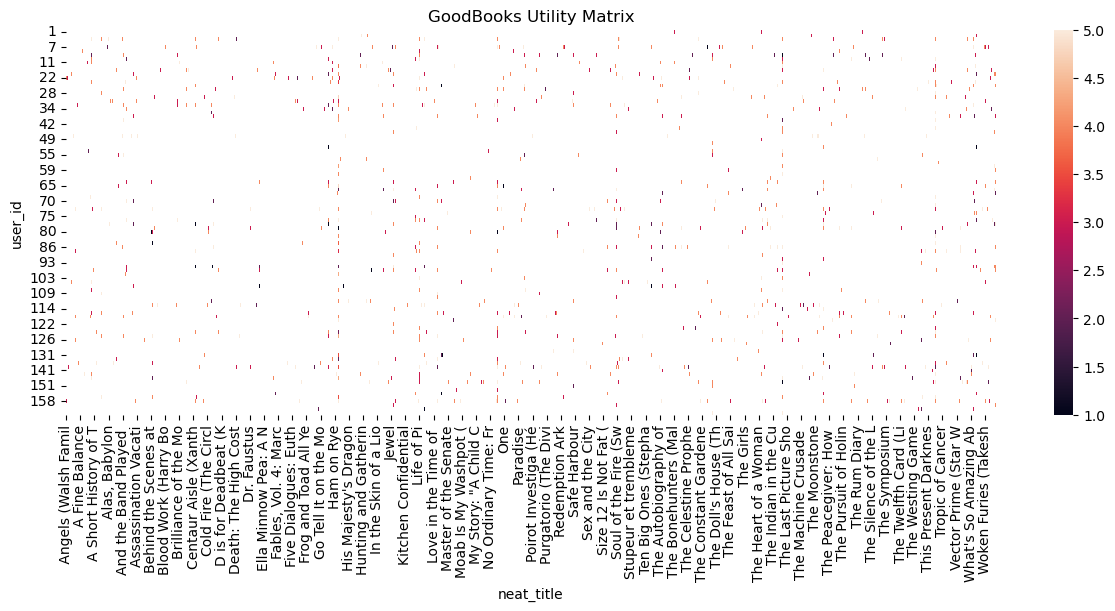

In [15]:
# Create a neat version of the utility matrix to assist with plotting book titles 
book_ratings['neat_title'] = book_ratings_reduced['title'].apply(lambda x: x[:20])
util_matrix_neat = book_ratings.pivot_table(index=['user_id'], 
                                            columns=['neat_title'],
                                            values='rating')

fig, ax = plt.subplots(figsize=(15,5))
# We select only the first 100 users for ease of computation and visualisation. 
# You can play around with this value to see more of the utility matrix. 
_ = sns.heatmap(util_matrix_neat[:100], annot=False, ax=ax).set_title('GoodBooks Utility Matrix')

Note that the white regions of the heatmap indicate cells in the utility matrix for which we have no rating data. 

With our utility matrix created, we now preprocess our data in preparation for similarity computation. This is done by normalising each user's set of ratings, filling in Nan values with 0, [transposing](https://www.khanacademy.org/math/linear-algebra/matrix-transformations/matrix-transpose/v/linear-algebra-transpose-of-a-matrix) our matrix for easier indexing, dropping users with no ratings, and storing the matrix in a sparse representation to save memory.   

In [16]:
# Normalize each row (a given user's ratings) of the utility matrix
util_matrix_norm = util_matrix.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)

# Fill Nan values with 0's, transpose matrix, and drop users with no ratings
util_matrix_norm.fillna(0, inplace=True)
util_matrix_norm = util_matrix_norm.T
util_matrix_norm = util_matrix_norm.loc[:, (util_matrix_norm != 0).any(axis=0)]

# Save the utility matrix in scipy's sparse matrix format
util_matrix_sparse = sp.sparse.csr_matrix(util_matrix_norm.values)

We can now compute the similarity between users based on the ratings they have given various books

In [17]:
# Compute the similarity matrix using the cosine similarity metric
user_similarity = cosine_similarity(util_matrix_sparse.T)
# Save the matrix as a dataframe to allow for easier indexing  
user_sim_df = pd.DataFrame(user_similarity, 
                           index = util_matrix_norm.columns, 
                           columns = util_matrix_norm.columns)

# Review a small portion of the constructed similarity matrix  
user_sim_df[:5]

user_id,1,2,4,7,8,9,10,11,15,18,...,1395,1400,1403,1406,1408,1409,1411,1413,1414,1415
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.102576,0.000000,0.000000,...,-0.040150,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.0,1.000000,0.035934,0.000000,0.000000,0.020235,0.024568,0.014285,0.020881,0.029688,...,0.017657,0.000000,0.017660,0.001598,0.117633,0.021856,0.000000,0.000000,0.073423,0.0
4,0.0,0.035934,1.000000,-0.006611,-0.001569,0.050590,0.150432,0.100861,0.007655,0.031947,...,0.070826,-0.034634,0.063563,0.032675,0.152044,0.035422,0.000306,0.000000,0.099694,0.0
7,0.0,0.000000,-0.006611,1.000000,0.017598,0.006583,-0.009283,-0.058847,-0.020181,-0.008304,...,-0.032315,0.000000,0.003164,0.019748,0.055032,-0.062160,0.000000,-0.015526,-0.018094,0.0
8,0.0,0.000000,-0.001569,0.017598,1.000000,-0.002181,-0.059559,0.000000,-0.024875,0.029769,...,0.000000,-0.082023,0.000296,0.000000,0.041742,0.001509,0.000000,0.000000,0.013745,0.0


With our similarity matrix formed, we are once again in a position to make some recommendations. 

As was the process for content-based filtering, we'll first look at generating top-N recommendations and then rating predictions using collaborative filtering.